# (14) Denoise

**Motivation**: host = ```Any```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: chewie

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from analysis.denoise import *

## Poisson

In [4]:
models2load = {
    'iter-pois': dict(
        model_name='poisson_MNIST_t-32_z-[128]_<jacob|mlp>',
        fit_name='u:(8.0)-du:(7.0)_b200-ep500-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,10:55)',
        device=device,
        shuffle=False,
    ),
    'iter-gaus': dict(
        model_name='gaussian_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>',
        fit_name='b200-ep500-lr(0.002)_beta(5:0x0.5)_gr(1000)_(2024_09_08,16:11)',
        device=device,
        shuffle=False,
    ),
    'amort-pois': dict(
        model_name='poisson_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep500-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,17:45)',
        device=device,
        shuffle=False,
    ),
    'amort-gaus': dict(
        model_name='gaussian_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep400-lr(0.002)_beta(1:0x0.1)_gr(50)_(2024_09_17,20:20)',
        device=device,
        shuffle=False,
    ),
}

In [6]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iter-pois']
shape = (-1, *tr.model.cfg.input_sz)

iter-pois

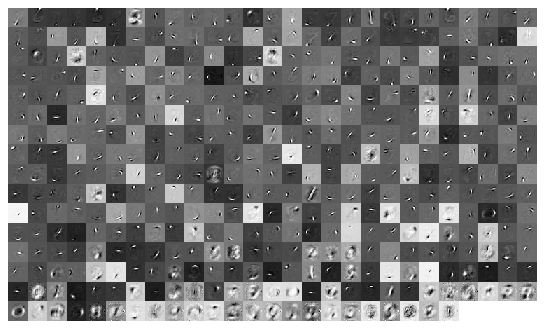

iter-gaus

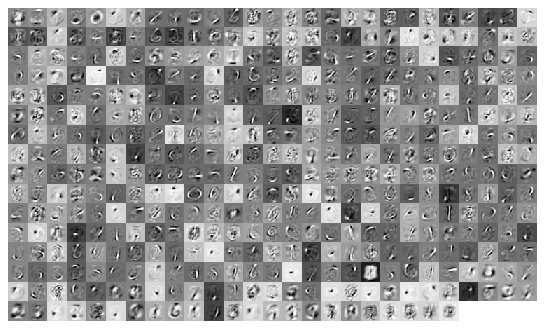

amort-pois

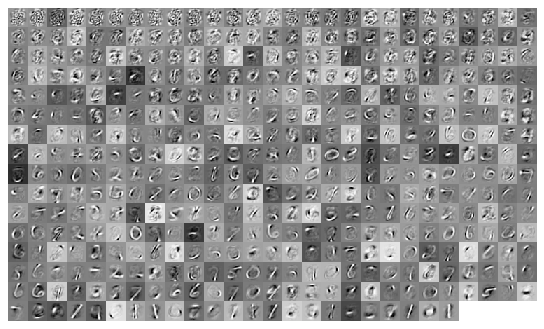

amort-gaus

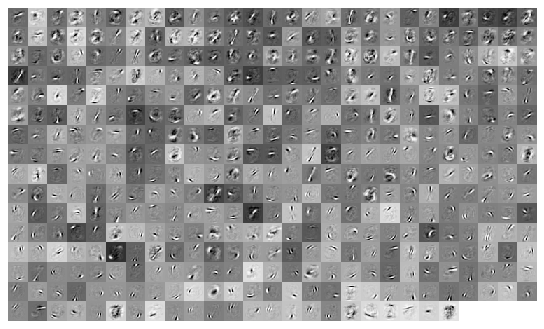

In [20]:
for name, tr in trainers.items():
    print(name)
    
    w = tr.model.layer.get_weight()
    norms = tonp(torch.linalg.vector_norm(w, dim=1))
    tr.model.show(order=np.argsort(norms), dpi=80, pad=0)

100%|█████████████████████████████████| 50/50 [02:11<00:00,  2.64s/it]


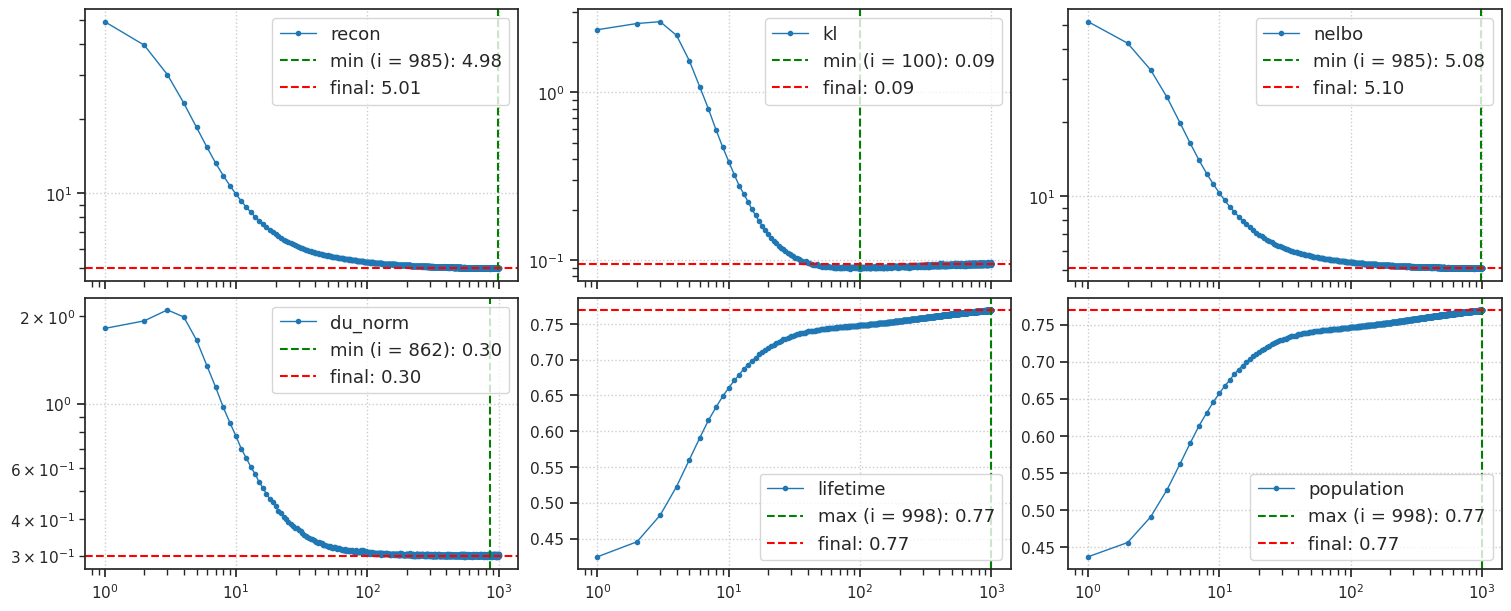

In [6]:
results = tr.analysis('vld', seq_total=1000)
_ = plot_convergence(results, color='C0')

## Iterative vs. Amortized

In [6]:
sigma = 1.2

In [7]:
kws = dict(
    tr=trainers['iterative'],
    sigma=sigma,
    t_recon=-1,
    verbose=False,
)
results, accuracy = perform_denoise_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:18<00:00, 16.65it/s]


In [8]:
accuracy, results['mse'].mean()

(0.7432, 23.55618)

In [12]:
## Was: sigma = 0.6

(0.9015, 10.4138155)

In [10]:
kws['tr'] = trainers['amortized']
results, accuracy = perform_denoise_analysis(**kws)

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 331.21it/s]


In [11]:
accuracy, results['mse'].mean()

(0.6188, 54.435425)

In [11]:
sigma = 1.2

In [12]:
kws = dict(
    tr=None,
    sigma=sigma,
    t_recon=100,
    verbose=False,
)
for name, tr in trainers.items():
    kws['tr'] = tr
    results, accuracy = perform_denoise_analysis(**kws)
    msg = ',  '.join([
        f"mse (mean) = {np.mean(results['mse']):0.1f}",
        f"mse (median) = {np.median(results['mse']):0.1f}",
        f"accuracy = {accuracy:0.3f}",
    ])
    msg = f"{name}   ———   {msg}"
    print(msg)

iter-pois   ———   mse (mean) = 23.5,  mse (median) = 23.1,  accuracy = 0.742

iter-gaus   ———   mse (mean) = 21.8,  mse (median) = 21.4,  accuracy = 0.738

amort-pois   ———   mse (mean) = 54.6,  mse (median) = 52.7,  accuracy = 0.620

amort-gaus   ———   mse (mean) = 43.7,  mse (median) = 41.3,  accuracy = 0.665

In [13]:
sigma = 0.3

In [14]:
kws = dict(
    tr=None,
    sigma=sigma,
    t_recon=100,
    verbose=False,
)
for name, tr in trainers.items():
    kws['tr'] = tr
    results, accuracy = perform_denoise_analysis(**kws)
    msg = ',  '.join([
        f"mse (mean) = {np.mean(results['mse']):0.1f}",
        f"mse (median) = {np.median(results['mse']):0.1f}",
        f"accuracy = {accuracy:0.3f}",
    ])
    msg = f"{name}   ———   {msg}"
    print(msg)

iter-pois   ———   mse (mean) = 5.7,  mse (median) = 5.6,  accuracy = 0.938

iter-gaus   ———   mse (mean) = 9.6,  mse (median) = 9.3,  accuracy = 0.864

amort-pois   ———   mse (mean) = 25.8,  mse (median) = 24.3,  accuracy = 0.931

amort-gaus   ———   mse (mean) = 16.3,  mse (median) = 15.5,  accuracy = 0.934

## MNIST + Gaussian Noise

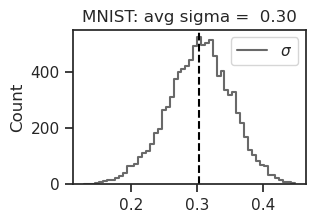

In [15]:
sd = torch.std(tr.dl_vld.dataset.tensors[0], dim=(1, 2, 3))
sd_avg = torch.mean(sd).item()

ax = sns.histplot(tonp(sd), element='step', fill=False, color='dimgrey', label=r"$\sigma$")
ax.axvline(sd_avg, color='k', ls='--')
ax.set_title(f"MNIST: avg sigma = {sd_avg: 0.2f}")
ax.legend()
plt.show()

In [16]:
tr.dl_vld.dataset.tensors[0].mean()

tensor(0.1325, device='cuda:1')

In [32]:
sigma = 0.3

In [33]:
t_recon = 64
t_halluc = 64
final_only = False

results = denoise_analysis(tr, sigma, t_recon=t_recon, final_only=final_only)
results_halluc = denoise_analysis(tr, sigma, t_recon=t_recon, t_halluc=t_halluc, hallucinate=True, final_only=final_only)

100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]


In [34]:
results['mse'].shape, results_halluc['mse'].shape

((10000, 64), (10000, 128))

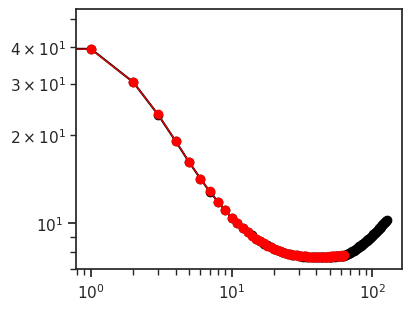

In [35]:
fig, ax = create_figure(1, 1, (4, 3), 'all', 'all')
ax.loglog(tonp(results_halluc['mse'].mean(0)), marker='o', color='k')
ax.loglog(tonp(results['mse'].mean(0)), marker='o', color='r', lw=0.8)
plt.show()

In [36]:
x = next(iter(tr.dl_vld))[0]
x_noisy = F_vis.gaussian_noise(
    inpt=x, sigma=sigma, clip=False)

### results (recon only)

In [37]:
best_times = np.argmin(results['mse'], axis=1)
y = results['recon'][np.arange(len(best_times)), best_times]
y.shape

(10000, 1, 28, 28)

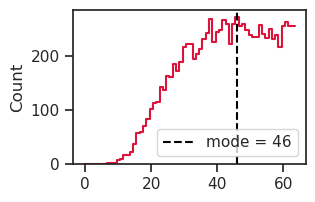

In [38]:
bins = np.linspace(0, t_recon, t_recon + 1) - 0.5

ax = histplot(
    best_times,
    bins=bins,
    color='crimson',
)
mode = sp_stats.mode(best_times).mode
ax.axvline(mode, color='k', ls='--', label=f"mode = {mode}")
add_legend(ax)
plt.show()

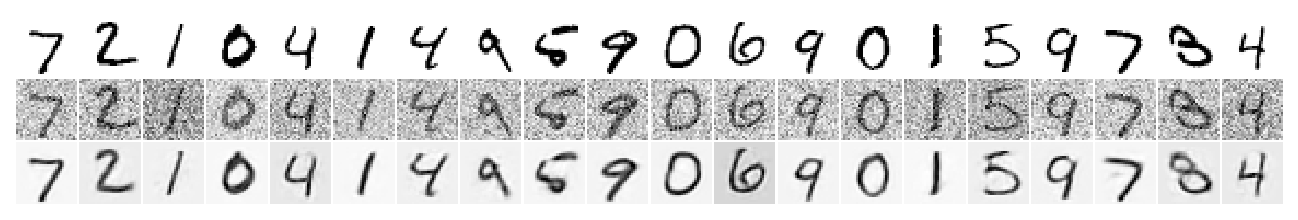

In [39]:
num = 20
x2p = np.concatenate([
    tonp(x[:num]),
    tonp(x_noisy[:num]),
    y[:num],
])

_ = plot_weights(x2p, nrows=3, cmap='Greys')

mse:
best times = 5.9,
mode timepoint = 7.7,

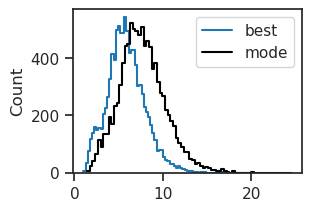

In [40]:
best_mse = results['mse'][np.arange(len(best_times)), best_times]
mode_mse = results['mse'][:, mode]

print(f"mse:\nbest times = {best_mse.mean():0.1f},\nmode timepoint = {mode_mse.mean():0.1f},")

fig, ax = create_figure()
histplot(best_mse, label='best', color='C0', ax=ax)
histplot(mode_mse, label='mode', color='k', ax=ax)
ax.legend()
plt.show()

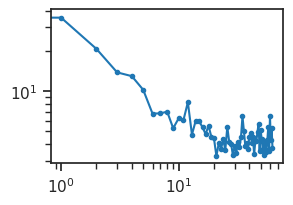

In [41]:
plt.loglog(results['mse'][0], marker='.')

### results (recon + hallucinate)

In [42]:
best_times = np.argmin(results_halluc['mse'], axis=1)
y = results_halluc['recon'][np.arange(len(best_times)), best_times]
y.shape

(10000, 1, 28, 28)

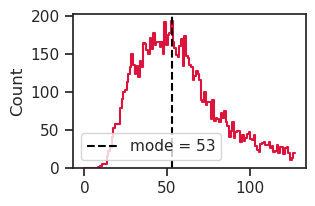

In [43]:
bins = np.linspace(0, t_recon + t_halluc, t_recon + t_halluc + 1) - 0.5

ax = histplot(
    best_times,
    bins=bins,
    color='crimson',
)
mode = sp_stats.mode(best_times).mode
ax.axvline(mode, color='k', ls='--', label=f"mode = {mode}")
add_legend(ax)
plt.show()

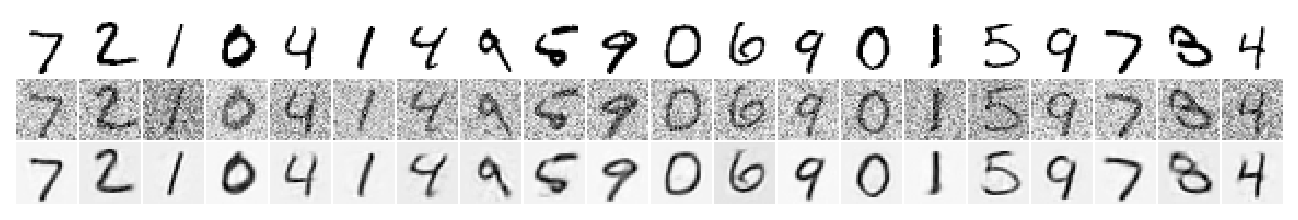

In [44]:
num = 20
x2p = np.concatenate([
    tonp(x[:num]),
    tonp(x_noisy[:num]),
    y[:num],
])

_ = plot_weights(x2p, nrows=3, cmap='Greys')

mse:
best times = 5.8,
mode timepoint = 7.7,

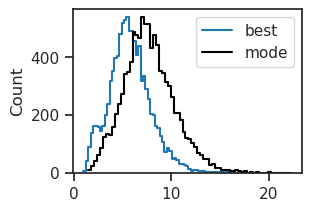

In [45]:
best_mse = results_halluc['mse'][np.arange(len(best_times)), best_times]
mode_mse = results_halluc['mse'][:, mode]

print(f"mse:\nbest times = {best_mse.mean():0.1f},\nmode timepoint = {mode_mse.mean():0.1f},")

fig, ax = create_figure()
histplot(best_mse, label='best', color='C0', ax=ax)
histplot(mode_mse, label='mode', color='k', ax=ax)
ax.legend()
plt.show()

## Dynamic noise?

In [6]:
sigma = 0.9
t_recon = 500

results = denoise_analysis(tr, sigma, t_recon=t_recon)
results_dyna = denoise_dynamic(tr, sigma, num_iters=t_recon * 10)

100%|███████████████████████████████████████████| 50/50 [09:36<00:00, 11.54s/it]


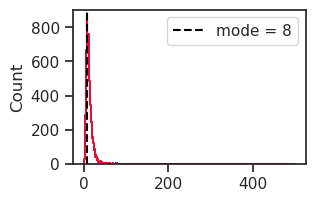

In [9]:
best_times = np.argmin(results['mse'], axis=1)
bins = np.linspace(0, t_recon, t_recon + 1) - 0.5

ax = histplot(
    best_times,
    bins=bins,
    color='crimson',
)
mode = sp_stats.mode(best_times).mode
ax.axvline(mode, color='k', ls='--', label=f"mode = {mode}")
add_legend(ax)
plt.show()

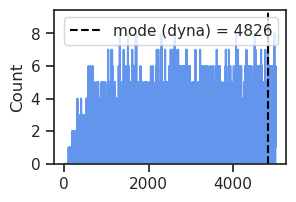

In [11]:
best_times_dyna = np.argmin(results_dyna['mse'], axis=1)

bins = np.linspace(0, t_recon * 10, t_recon * 10 + 1) - 0.5

ax = histplot(
    best_times_dyna,
    bins=bins,
    color='cornflowerblue',
)
mode_dyna = sp_stats.mode(best_times_dyna).mode
ax.axvline(mode_dyna, color='k', ls='--', label=f"mode (dyna) = {mode_dyna}")
add_legend(ax)
plt.show()

mse: best times = 16.7,   mode timepoint = 21.5

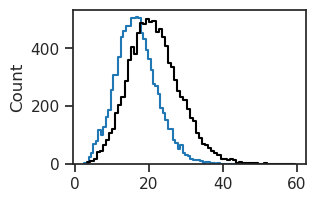

In [12]:
best_mse = results['mse'][np.arange(len(best_times)), best_times]
mode_mse = results['mse'][:, mode]

histplot(best_mse, color='C0')
histplot(mode_mse, color='k')

print(f"mse: best times = {best_mse.mean():0.1f},   mode timepoint = {mode_mse.mean():0.1f}")

mse: best times = 3.9,   mode timepoint = 5.7

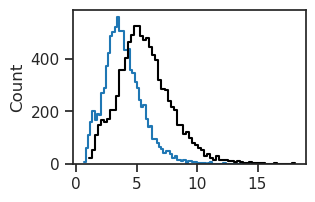

In [13]:
best_mse_dyna = results_dyna['mse'][np.arange(len(best_times_dyna)), best_times_dyna]
mode_mse_dyna = results_dyna['mse'][:, mode_dyna]

histplot(best_mse_dyna, color='C0')
histplot(mode_mse_dyna, color='k')

print(f"mse: best times = {best_mse_dyna.mean():0.1f},   mode timepoint = {mode_mse_dyna.mean():0.1f}")

In [14]:
x = next(iter(tr.dl_vld))[0]
x_eps = F_vis.gaussian_noise(
    inpt=x, sigma=sigma, clip=False)

x = tonp(x)
x_eps = tonp(x_eps)

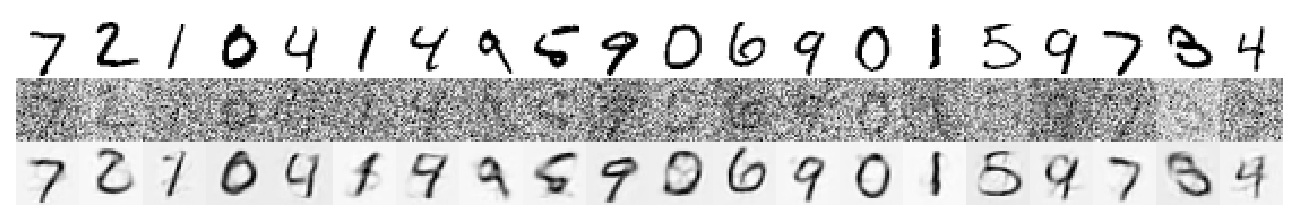

In [15]:
best_times = np.argmin(results['mse'], axis=1)
y = results['recon'][np.arange(len(best_times)), best_times, :]
y = y.reshape(shape)

num = 20
x2p = np.concatenate([x[:num], x_eps[:num], y[:num]])
_ = plot_weights(x2p, nrows=3, pad=0, cmap='Greys')

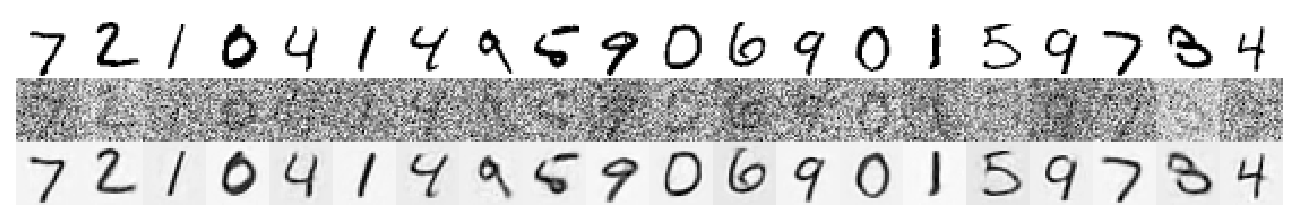

In [16]:
best_times_dyna = np.argmin(results_dyna['mse'], axis=1)
y = results_dyna['recon'][np.arange(len(best_times_dyna)), best_times_dyna, :]
y = y.reshape(shape)

num = 20
x2p = np.concatenate([x[:num], x_eps[:num], y[:num]])
_ = plot_weights(x2p, nrows=3, pad=0, cmap='Greys')

## Clf

### Fixed noise

In [30]:
sigma = 1.2
t_recon = 100

kws = dict(
    sigma=sigma,
    t_recon=t_recon,
    tr=trainers['iterative'],
    full_data=True,
)

results = {
    name: denoise_analysis(
        dl_name=name, **kws)
    for name in ['vld', 'trn']
}

100%|█████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s]


In [31]:
best_times = {
    name: np.argmin(d['mse'], axis=1)
    for name, d in results.items()
}

<Axes: ylabel='Percent'>

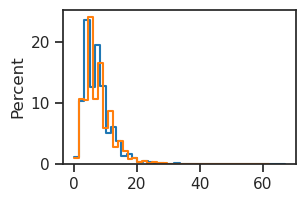

In [32]:
histplot(best_times['vld'], bins=40, stat='percent')
histplot(best_times['trn'], bins=40, stat='percent')

In [33]:
z_trn = np.exp(results['trn']['state'])
z_vld = np.exp(results['vld']['state'])
g_trn = results['trn']['g'].astype(int)
g_vld = results['vld']['g'].astype(int)

In [34]:
{
    name: sp_stats.mode(b).mode for
    name, b in best_times.items()
}

{'vld': 5, 'trn': 5}

In [35]:
mode = np.concatenate(list(best_times.values()))
mode = sp_stats.mode(mode).mode
mode

5

In [37]:
print({
    name: d['mse'].mean(0)[mode]
    for name, d in results.items()
})

{'vld': 29.015638, 'trn': 29.142458}

In [18]:
z_trn = z_trn[:, mode]
z_vld = z_vld[:, mode]

# z_trn = z_trn[np.arange(len(z_trn)), best_times['trn']]
# z_vld = z_vld[np.arange(len(z_vld)), best_times['vld']]

# z_trn = z_trn[:, -1, :]
# z_vld = z_vld[:, -1, :]

In [19]:
clf = LogisticRegression(C=1.0).fit(
    z_trn, g_trn)
clf_report = classification_report(
    y_true=g_vld,
    y_pred=clf.predict(z_vld),
    output_dict=True,
)
print(clf_report['accuracy'])

0.7381

In [35]:
## Was: mode of best time points (so a shared time point)

0.8227

In [26]:
## Was: best time point

0.8273

In [13]:
## Was: last time point

0.7039

### Dynamic noise

In [43]:
# sigma = 0.9
num_iters = 1000

kws = dict(
    sigma=sigma,
    num_iters=num_iters,
    tr=trainers['iterative'],
    final_only=True,
)

results = {
    name: denoise_dynamic(
        dl_name=name, **kws)
    for name in ['vld', 'trn']
}

100%|█████████████████████████████████████████| 300/300 [09:21<00:00,  1.87s/it]


In [21]:
{k: v.shape for k, v in results['trn'].items()}

{'ff': (60000, 1, 128),
 'mse': (60000, 1),
 'state': (60000, 1, 128),
 'recon': (60000, 1, 784),
 'g': (60000,)}

In [22]:
print({
    name: d['mse'].mean() for
    name, d in results.items()
})

{'vld': 6.3214483, 'trn': 6.2477875}

In [23]:
z_trn = np.exp(results['trn']['state'][:, -1, :])
z_vld = np.exp(results['vld']['state'][:, -1, :])
g_trn = results['trn']['g'].astype(int)
g_vld = results['vld']['g'].astype(int)

In [24]:
clf = LogisticRegression(C=1.0).fit(
    z_trn, g_trn)
clf_report = classification_report(
    y_true=g_vld,
    y_pred=clf.predict(z_vld),
    output_dict=True,
)
print(clf_report['accuracy'])

0.9433

In [25]:
samples = torch.poisson(tr.to(z_trn))
(samples == 0).sum() / samples.numel()

tensor(0.5548, device='cuda:1')

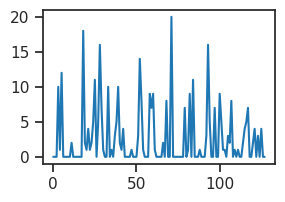

In [26]:
plt.plot(tonp(samples[7]))

In [27]:
z_trn.mean(0)

array([2.70988  , 1.6612743, 2.572832 , 2.26297  , 2.6460009, 2.2031116,
       2.2897434, 2.088819 , 2.0908637, 2.6075766, 2.1462607, 2.8746266,
       2.506736 , 2.6701744, 2.7514224, 2.1149023, 2.333152 , 2.8145397,
       2.8107858, 2.2769113, 2.9256024, 2.418103 , 2.214506 , 2.3472874,
       1.7970917, 2.9864721, 2.4985495, 2.718637 , 2.8308127, 2.5588403,
       2.4441366, 2.3977451, 2.7532032, 2.4701455, 2.5165768, 2.169701 ,
       2.9066515, 2.6924424, 2.8162518, 3.2278893, 2.5342662, 3.3422408,
       2.4141214, 2.329927 , 3.123119 , 3.0695148, 3.8495326, 2.9409375,
       2.118292 , 2.3850675, 2.1796892, 3.004088 , 2.2995374, 2.2899568,
       2.7182682, 2.7225142, 2.7058103, 2.439377 , 3.0303872, 2.2890308,
       2.5584505, 1.444296 , 2.2560918, 2.0429192, 2.493105 , 2.1739275,
       2.4693868, 2.7699375, 2.427317 , 2.58775  , 2.5551195, 3.08253  ,
       2.0653446, 2.322336 , 1.9100556, 2.360304 , 2.6606843, 2.3453157,
       3.2148342, 3.6768088, 3.0736227, 3.3639805, 

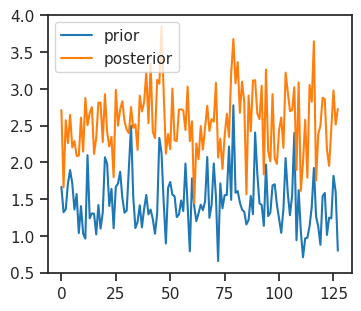

In [28]:
fig, ax = create_figure(1, 1, (3.5, 3))
ax.plot(tonp(tr.model.layer.log_rate.exp().ravel()), label='prior')
ax.plot(tonp(z_trn.mean(0).ravel()), label='posterior')
ax.legend()
plt.show()

In [29]:
sp_stats.pearsonr(
    tonp(tr.model.layer.log_rate.exp().ravel()),
    tonp(z_trn.mean(0).ravel()),
)

PearsonRResult(statistic=0.45498691894263477, pvalue=6.831194001482211e-08)

### Was: all time points
(# iters = 1000)

In [8]:
{k: v.shape for k, v in results['trn'].items()}

{'ff': (60000, 13, 128),
 'mse': (60000, 13),
 'state': (60000, 13, 128),
 'recon': (60000, 13, 784),
 'g': (60000,)}

In [9]:
best_times = {
    name: np.argmin(d['mse'], axis=1)
    for name, d in results.items()
}

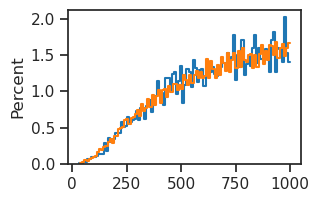

In [10]:
histplot(best_times['vld'], bins=100, stat='percent')
histplot(best_times['trn'], bins=100, stat='percent');

In [20]:
z_trn = np.exp(results['trn']['state'])
z_vld = np.exp(results['vld']['state'])
g_trn = results['trn']['g'].astype(int)
g_vld = results['vld']['g'].astype(int)

In [12]:
{
    name: sp_stats.mode(b).mode for
    name, b in best_times.items()
}

{'vld': 838, 'trn': 892}

In [14]:
mode = np.concatenate(list(best_times.values()))
mode = sp_stats.mode(mode).mode
mode

975

In [21]:
# z_trn = z_trn[:, mode]
# z_vld = z_vld[:, mode]

# z_trn = z_trn[np.arange(len(z_trn)), best_times['trn']]
# z_vld = z_vld[np.arange(len(z_vld)), best_times['vld']]

z_trn = z_trn[:, -1, :]
z_vld = z_vld[:, -1, :]

In [16]:
## Was: mode of best time points (so a shared time point)

0.9453

In [19]:
## Was: best time point

0.9493

In [22]:
## Was: last time point

0.9449

In [ ]:
### These were fixed noise:

In [35]:
## Was: mode of best time points (so a shared time point)

0.8227

In [26]:
## Was: best time point

0.8273

In [13]:
## Was: last time point

0.7039

## High sigma

$\sigma = 1.2$

In [44]:
x = next(iter(tr.dl_vld))[0]

In [45]:
sigma = 1.2

x_eps = F_vis.gaussian_noise(
    inpt=x, sigma=sigma, clip=False)

In [46]:
x = tonp(x)
x_eps = tonp(x_eps)

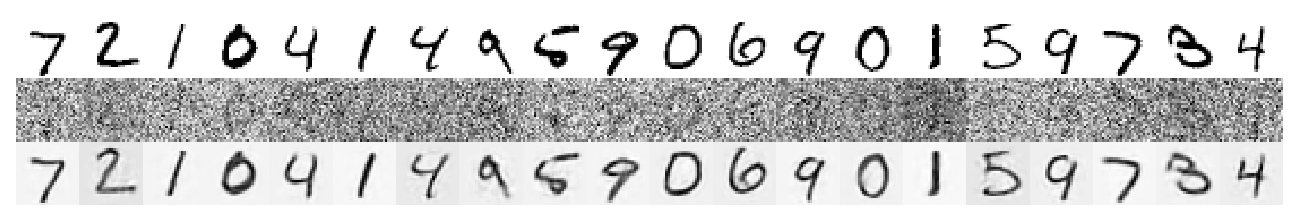

In [47]:
best_times = np.argmin(results['vld']['mse'], axis=1)
y = results['vld']['recon'][np.arange(len(best_times)), best_times, :]
y = y.reshape(shape)

num = 20
x2p = np.concatenate([x[:num], x_eps[:num], y[:num]])
_ = plot_weights(x2p, nrows=3, pad=0, cmap='Greys')

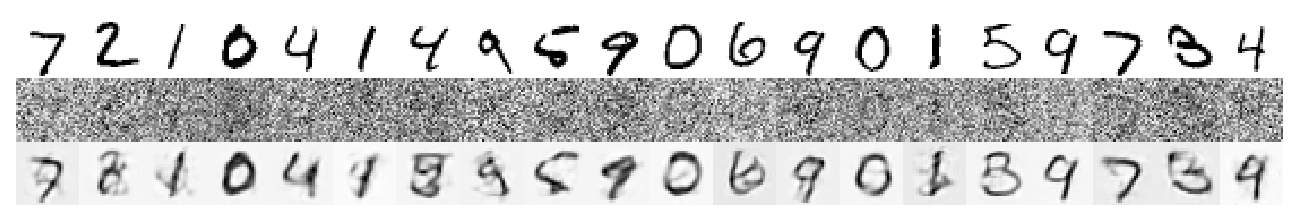

In [42]:
## Was: passive noise